# The reviews data

The data comes as a collection of json files. We can import these in an easy way with the following script (We only use the video games data)

In [1]:
import numpy as np
import pandas as pd
import gzip
%matplotlib inline  

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_reviews = getDF('./data/reviews_Video_Games_5.json.gz')
df_meta=getDF('./data/meta_Video_Games.json.gz')

#df_qa_toys_and_games = getDF('./data/qa_Toys_and_Games.json.gz')
#df_QA_toys_and_games = getDF('./data/QA_Toys_and_Games.json.gz')

We take a quick look at the data first. The reviews dataframe

In [2]:
df_reviews.head()

,helpful,reviewTime,reviewText,reviewerID,asin,unixReviewTime,overall,reviewerName,summary
0,"[8, 12]","07 9, 2012",Installing the game was a struggle (because of...,A2HD75EMZR8QLN,0700099867,1341792000,1.0,123,Pay to unlock content? I don't think so.
1,"[0, 0]","06 30, 2013",If you like rally cars get this game you will ...,A3UR8NLLY1ZHCX,0700099867,1372550400,4.0,"Alejandro Henao ""Electronic Junky""",Good rally game
2,"[0, 0]","06 28, 2014",1st shipment received a book instead of the ga...,A1INA0F5CWW3J4,0700099867,1403913600,1.0,"Amazon Shopper ""Mr.Repsol""",Wrong key
3,"[7, 10]","09 14, 2011","I got this version instead of the PS3 version,...",A1DLMTOTHQ4AST,0700099867,1315958400,3.0,ampgreen,"awesome game, if it did not crash frequently !!"
4,"[2, 2]","06 14, 2011",I had Dirt 2 on Xbox 360 and it was an okay ga...,A361M14PU2GUEG,0700099867,1308009600,4.0,"Angry Ryan ""Ryan A. Forrest""",DIRT 3


and the meta data

In [3]:
df_meta.head()

,related,salesRank,asin,description,imUrl,price,categories,brand,title
0,"{'bought_together': ['B002I098JE'], 'also_boug...",{'Video Games': 28655},0078764343,Brand new sealed!,http://ecx.images-amazon.com/images/I/513h6dPb...,37.98,"[[Video Games, Xbox 360, Games]]",NaN,NaN
1,"{'also_viewed': ['B000067NP1', '0439573947', '...",{'Video Games': 44080},043933702X,In Stock NOW. Eligible for FREE Super Saving ...,http://ecx.images-amazon.com/images/I/61KKRndV...,23.50,"[[Video Games, PC, Games]]",NaN,NaN
2,"{'buy_after_viewing': ['B00004UCUS', 'B000YFIS...",{'Video Games': 49836},0439339987,Grandma Groupers kelp seeds are missing and wi...,http://ecx.images-amazon.com/images/I/416QZg89...,8.95,"[[Video Games, PC, Games]]",NaN,NaN
3,{'also_viewed': ['043934302X']},{'Video Games': 49156},0439342260,This software is BRAND NEW. Packaging may diff...,http://ecx.images-amazon.com/images/I/61Wvu-Uj...,NaN,"[[Video Games, PC, Games]]",NaN,NaN
4,{'also_viewed': ['B00028D7TG']},{'Video Games': 52262},0439339960,a scholastic clubs fairs cd rom game,http://ecx.images-amazon.com/images/I/51k3oRCF...,NaN,"[[Video Games, PC, Games]]",NaN,NaN


For our purposes, it is important to see that the related feature has indeed more data, more precisely

In [4]:
df_meta.related.iloc[0]

{'also_bought': ['B000TI836G',
  'B003Q53VZC',
  'B00EFFW0HC',
  'B003VWGBC0',
  'B003O6G5TW',
  'B0037LTTRO',
  'B002I098JE',
  'B008OQTS0U',
  'B005EVEODY',
  'B008B3AVNE',
  'B000PE0HBS',
  'B00354NAYG',
  'B0050SYPV2',
  'B00503E8S2',
  'B0050SY77E',
  'B0022TNO7S',
  'B0056WJA30',
  'B0023CBY4E',
  'B002SRSQ72',
  'B005EZ5GQY',
  'B004XACA60',
  'B00273Z9WM',
  'B004HX1QFY',
  'B002I0K50U'],
 'bought_together': ['B002I098JE'],
 'buy_after_viewing': ['B0050SY5BM', 'B000TI836G', 'B0037LTTRO', 'B002I098JE']}

that is related is a dictionary with 3 keys 'also_bought', 'bought_together', and 'buy_after_viewing'

# Reviews in time

We want to understand when a product is released and try to figure what info we can get out of this, to do so we start by creating a collection of the reviews and the review time.

In [5]:
review_time=(df_reviews[['unixReviewTime','asin']].groupby('asin')
     .agg(lambda x:(list(x))))
review_time=review_time.applymap(lambda x: np.sort(np.array(x)));
review_time['initial']=review_time['unixReviewTime'].apply(lambda x:x[0])
review_time['review_days']=(review_time['unixReviewTime']-review_time['initial'])//(3600*24)
review_time=review_time.drop('unixReviewTime',axis=1)
review_time['day_last_review']=review_time['review_days'].apply(lambda x:x[-1])
review_time['nb_reviews']=review_time['review_days'].apply(lambda x:len(x))

We now graph the number of reviews against the days after the first review.

In [6]:
from collections import Counter
def create(days):
    X=[days[0]]
    Y=[0]
    current=0
    for day in days:
        if day==X[-1]:
            Y[current]+=1
        else:
            X.append(day)
            Y.append(Y[-1]+1)
            current+=1
    return X,Y

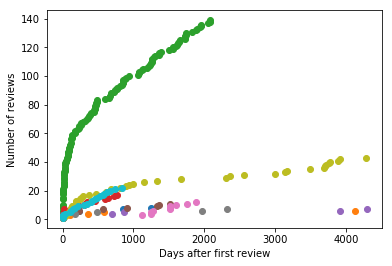

In [7]:
import matplotlib.pyplot as plt

sample=review_time.sample(10)
for days in sample.review_days:
    
    X,Y=create(days)
    #print(X,Y)
    plt.plot(X, Y,'o')
    
plt.xlabel("Days after first review")
plt.ylabel("Number of reviews")
plt.show()

Let's make the following assumption:

**Assumption: The "better" a product is, the more reviews it would have when measure over periods of time**

In order to make this concrete, we can create a new invariant, we define 

**hotness** = area under the staircase formed by the curve in the interval where it is defined.


In [8]:
def compute_hotness(days):
    X,Y=create(days)
    #X=[0,20,30]
    #Y=[1,2,3]
    area=0
    for i in range(1,len(X)):
        area+=(X[i]-X[i-1])*Y[i-1]
    area+=Y[-1]

    return area

Let's add this feature

In [9]:
review_time['hotness']=review_time['review_days'].apply(lambda x:compute_hotness(x))

let's see if there's a correlation between hotness and salesrank.

In [10]:
review_time=review_time.reset_index()

In [11]:
def helper(x):
    try:
        return int(str(x)[16:-1])
    except:
        return float('NaN')

In [12]:
review_time2=review_time.merge(df_meta[['asin','salesRank']],on='asin')
review_time2['salesRank']=review_time2.salesRank.map(lambda x: helper(x))
review_time2=review_time2[review_time2['salesRank'].notnull()]

Let's look for correlations between this variables.

In [13]:
review_time2[['hotness','salesRank','day_last_review','nb_reviews']].corr()

,hotness,salesRank,day_last_review,nb_reviews
hotness,1.000000,-0.168000,0.379690,0.713013
salesRank,-0.168000,1.000000,0.127522,-0.292436
day_last_review,0.379690,0.127522,1.000000,0.016765
nb_reviews,0.713013,-0.292436,0.016765,1.000000


Let's look at the data

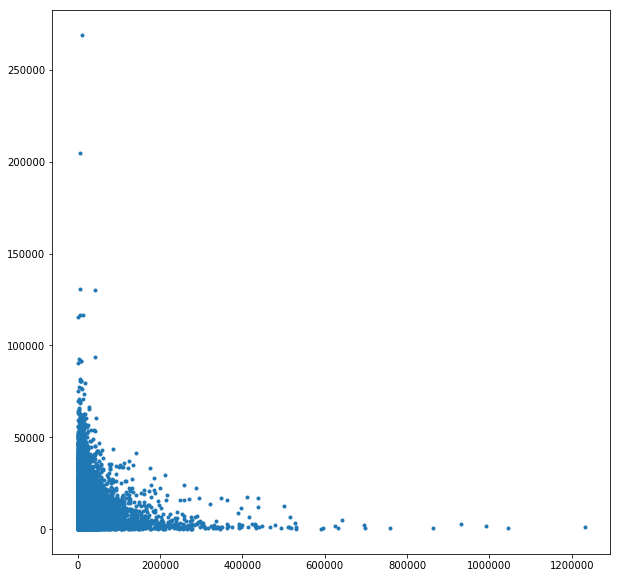

In [25]:
plt.figure(figsize=(10,10))
plt.plot(review_time2['hotness'], (review_time2['salesRank']), '.')
plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
model = RandomForestRegressor()

In [19]:
X=np.array([review_time2['day_last_review'],review_time2['nb_reviews'],review_time2['hotness']])

In [20]:
X=X.T

In [21]:
y=np.array(review_time2['salesRank'])

In [22]:
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [23]:
model.feature_importances_

array([ 0.36062527,  0.2436118 ,  0.39576293])

In [24]:
model.score(X,y)

0.85067018181235721

In [49]:
np.mean(np.around(np.abs(model.predict(X[:2000])-y[:2000])/y[:2000],decimals=2))

0.29785

## Questions:

- How to improve these scores.
- There are products that are seasonal.

# Predicting sale ranking from early reviews.

The goal here is to be able to predict the sales ranking, which in turn is corralated with the profit of the product. What is a good model for this?

In [51]:
review_time.nb_reviews.describe()

count    10672.000000
mean        21.718516
std         34.068551
min          5.000000
25%          7.000000
50%         11.000000
75%         22.000000
max        802.000000
Name: nb_reviews, dtype: float64